# 🚀 CS:GO Initial ML (PyCaret)
This notebook aims at using PyCaret to model CS:GO players dataset.
First we use ``compare_model()`` method to evaluate a set of available methods.
Afterwards, we will use the best model to create a ML model and tune it.
Finally we report the results in the form of confusion matrix and basic metrics.

In [1]:
# Required Modluels
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import pycaret
from sklearn.model_selection import train_test_split

from collections import defaultdict

import pycaret
from pycaret.classification import *

# from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


import sys
import platform
from datetime import date
print(f"  System: {sys.platform}")
print(f"  Python version: {platform.python_version()}")
print(f"  Last update: {date.today().strftime('%Y-%m-%d')}")

  System: darwin
  Python version: 3.11.8
  Last update: 2024-05-01


# 📊 Dataset
**Note:** The dataset used in this notebook is subject to change.

In [2]:
# Load dataset

# Paths to save
folder_model_path = f"models"
folder_eval_path = f"evaluation/metrics/"
folder_report_path = f"evaluation/reports"

folder_prediction_path = f"predictions"

# Path to load datasets
folder_data_ml_path = f"data/"
folder_processed_path = f"data/processed"


players_df = pd.read_csv('data/players.csv')
results_df = pd.read_csv('data/results.csv')

df = pd.read_csv('updated_players.csv')
df.head()

,date,player_name,team,opponent,country,player_id,match_id,event_id,event_name,best_of,...,m3_adr_ct,m3_kast_ct,m3_rating_ct,m3_kills_t,m3_deaths_t,m3_kddiff_t,m3_adr_t,m3_kast_t,m3_rating_t,team_won
0,2020-02-26,Brehze,Evil Geniuses,Liquid,United States,9136,2339385,4901,IEM Katowice 2020,3,...,72.5,80.0,0.93,7.0,9.0,-2.0,70.4,63.6,0.89,0.0
1,2020-02-26,CeRq,Evil Geniuses,Liquid,Bulgaria,11219,2339385,4901,IEM Katowice 2020,3,...,79.5,53.3,1.12,4.0,8.0,-4.0,40.7,54.5,0.53,0.0
2,2020-02-26,EliGE,Liquid,Evil Geniuses,United States,8738,2339385,4901,IEM Katowice 2020,3,...,81.5,63.6,1.03,9.0,9.0,0.0,87.9,73.3,1.05,1.0
3,2020-02-26,Ethan,Evil Geniuses,Liquid,United States,10671,2339385,4901,IEM Katowice 2020,3,...,67.2,66.7,0.97,1.0,9.0,-8.0,14.8,45.5,0.31,0.0
4,2020-02-26,NAF,Liquid,Evil Geniuses,Canada,8520,2339385,4901,IEM Katowice 2020,3,...,72.9,81.8,0.96,8.0,7.0,1.0,56.3,80.0,0.99,1.0


In [3]:
df.columns

Index(['date', 'player_name', 'team', 'opponent', 'country', 'player_id',
       'match_id', 'event_id', 'event_name', 'best_of',
       ...
       'm3_adr_ct', 'm3_kast_ct', 'm3_rating_ct', 'm3_kills_t', 'm3_deaths_t',
       'm3_kddiff_t', 'm3_adr_t', 'm3_kast_t', 'm3_rating_t', 'team_won'],
      dtype='object', length=102)

In [4]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 383317 entries, 0 to 383316
Data columns (total 102 columns):
 #    Column            Non-Null Count   Dtype  
---   ------            --------------   -----  
 0    date              383317 non-null  object 
 1    player_name       383316 non-null  object 
 2    team              383317 non-null  object 
 3    opponent          383317 non-null  object 
 4    country           383317 non-null  object 
 5    player_id         383317 non-null  int64  
 6    match_id          383317 non-null  int64  
 7    event_id          383317 non-null  int64  
 8    event_name        383317 non-null  object 
 9    best_of           383317 non-null  int64  
 10   map_1             383317 non-null  object 
 11   map_2             196523 non-null  object 
 12   map_3             68678 non-null   object 
 13   kills             383317 non-null  int64  
 14   assists           383317 non-null  int64  
 15   deaths            383317 non-null  int64  
 16   

# 🤓 Preprocess Data
In this section, we will preprocess the dataset and get it ready for Machine Learning

In [5]:
df.shape

(383317, 102)

In [6]:
df.dropna(subset=['team_won'], inplace=True)


df = df[df['best_of']>= 3]
df.shape

(121029, 102)

In [7]:
columns_to_keep = [
    'date', 
    # 'player_name', 
    'team', 'opponent', 'country',
    'player_id', 'match_id', 'event_id', 'event_name',
    'best_of', 'map_1','map_2','map_3','team_won', 
    'm1_kills', 'm1_assists', 'm1_deaths', 'm1_hs', 'm1_flash_assists',
    'm1_kast', 'm1_kddiff', 'm1_adr', 'm1_fkdiff', 'm1_rating'
]


df = df[columns_to_keep]
df.shape

(121029, 23)

In [8]:
match_ids = list(df['match_id'].unique())
print(len(match_ids))

12122


In [9]:
df_new = pd.DataFrame(columns=df.columns)

In [10]:
df_res = pd.read_csv('data/results.csv', low_memory=False)

In [11]:
rows = []
counter = 0
for m in match_ids:
    mask = df['match_id'] == m
    df_mask = df[mask].copy()
    df_matchres = df_res[df_res['match_id'] == m].copy()
    df_matchres = df_matchres[df_mask.iloc[0]['map_1'] == df_matchres['_map']].copy()
    # print(df_matchres)
    # wins = {col: df_matchres[col].sum() for col in m1_columns}
    teams = list(df_mask['team'].unique())
    for t in teams:
        # print(t)
        mask_team = df_mask['team'] == t
        df_mask_team = df_mask[mask_team].copy()
        # print(df_mask_team)
        new_row = df_mask_team.iloc[0].copy()
        # print(new_row)
        m1_columns = [col for col in df_mask_team.columns if col.startswith('m1_')]
        # for index, row in df_mask_team[m1_columns].iterrows():
            # print(row)
        means = {col: df_mask_team[col].sum() for col in m1_columns}
        # print(means)
        for col, mean_value in means.items():
            # print("col is: ", col)
            # print("mean is: ", val)
            new_row[col] = mean_value
        if(t == df_matchres.iloc[0]['team_1']):
            if(df_matchres.iloc[0]['map_winner'] == 1):
                new_row['match_win'] = 1
            else:
                new_row['match_win'] = 0
        else:
            if(df_matchres.iloc[0]['map_winner'] == 2):
                new_row['match_win'] = 1
            else:
                new_row['match_win'] = 0
        rows.append(new_row)
        # print(new_row)
        # df_new.loc[len(df_new)] = new_row
        # df_new = pd.concat([df_new, new_row.to_frame().T], ignore_index=True)
df_new = pd.DataFrame(rows)
df_new.to_csv('test.csv', index=False)
# print(df_new.head())
            
        # print(df_mask_team[m1_columns])
            
# df_mask.info(verbose=True)
# print(counter)

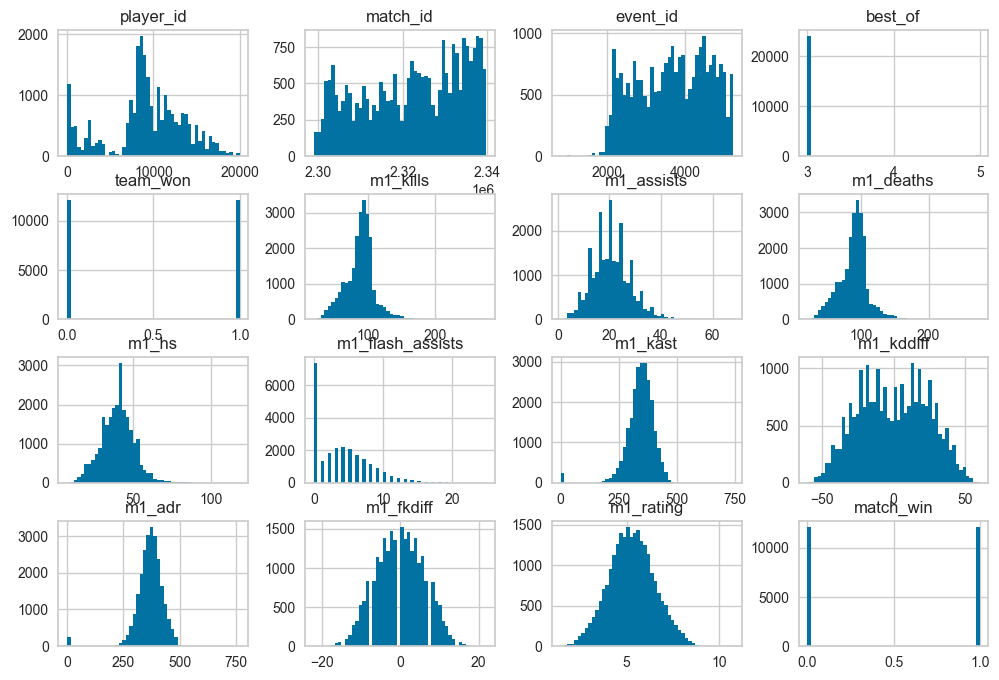

In [12]:
df_new.hist(bins=50, figsize=(12,8))
plt.show()

In [13]:
df_new['team'].value_counts()

team
Tricked         270
TYLOO           270
Liquid          252
Spirit          245
Heroic          243
               ... 
ex-Synthetik      1
Otter             1
KUURA             1
Retired           1
NEO Blue          1
Name: count, Length: 1283, dtype: int64

In [14]:
df_corr = df_new.drop(columns=[
                        'date', 
                    # 'player_name', 
                    'team', 'opponent',
                    'country',
                        'player_id', 'match_id', 'event_id', 'event_name',
                     'best_of', 'map_1', 'map_2', 'map_3'
                    ])

In [15]:
corr = df_corr.corr()

In [16]:
corr['team_won'].sort_values(ascending=False)

team_won            1.000000
match_win           0.608366
m1_kddiff           0.558296
m1_rating           0.529772
m1_kast             0.393869
m1_adr              0.384345
m1_fkdiff           0.373999
m1_kills            0.303754
m1_hs               0.252494
m1_assists          0.222129
m1_flash_assists    0.100516
m1_deaths          -0.302401
Name: team_won, dtype: float64

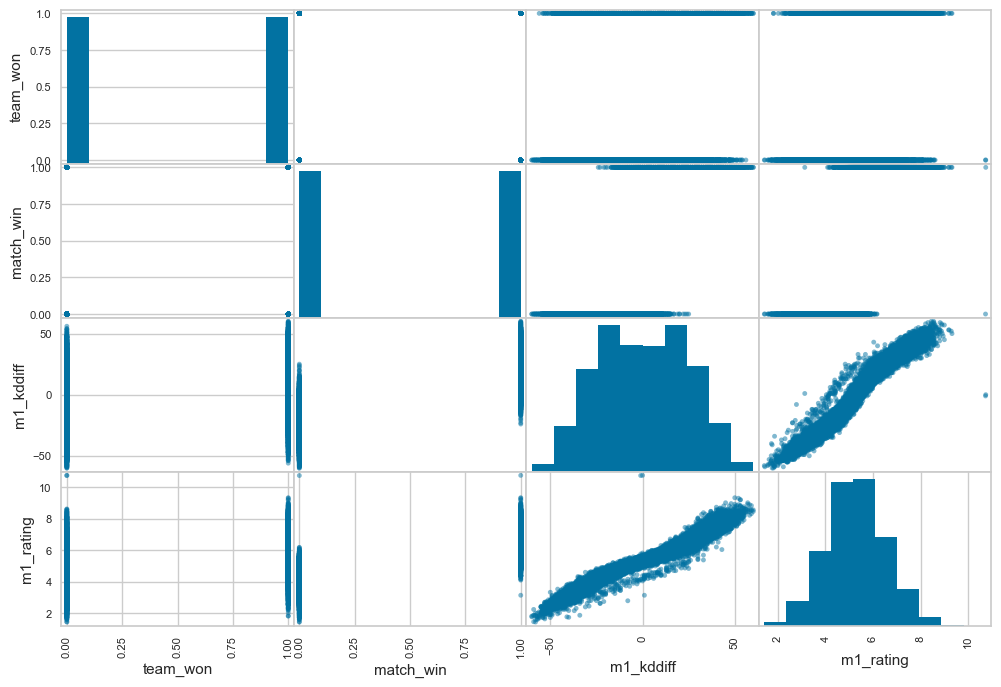

In [17]:
from pandas.plotting import scatter_matrix
attributes = ['team_won','match_win','m1_kddiff','m1_rating']
scatter_matrix(df_corr[attributes], figsize=(12, 8))
plt.show()

In [18]:
train_set, test_set = train_test_split(df_new, test_size=0.2, random_state=42)

In [19]:
X_train = train_set.drop('team_won',axis=1)
y_train = train_set['team_won'].copy()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19393 entries, 366214 to 357695
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              19393 non-null  object 
 1   team              19393 non-null  object 
 2   opponent          19393 non-null  object 
 3   country           19393 non-null  object 
 4   player_id         19393 non-null  int64  
 5   match_id          19393 non-null  int64  
 6   event_id          19393 non-null  int64  
 7   event_name        19393 non-null  object 
 8   best_of           19393 non-null  int64  
 9   map_1             19393 non-null  object 
 10  map_2             19373 non-null  object 
 11  map_3             7680 non-null   object 
 12  m1_kills          19393 non-null  int64  
 13  m1_assists        19393 non-null  int64  
 14  m1_deaths         19393 non-null  int64  
 15  m1_hs             19393 non-null  int64  
 16  m1_flash_assists  19393 non-null  float

# 🌎 General ML models
In this section, we create an experiment to evaluate different models. To this end, we require to perform the following steps:
1. Create an experiment object
2. Create a setup dictionary and setup the environment
3. perfomt the model comparison
4. evaluate model to observe the initial performance

In [20]:
# Define PyCaret classificaiton experimetn
obj_exp = ClassificationExperiment()

In [21]:
# Configure and build the setup environment
steup_dict= {
                "data": df_new,
                "fold": 10,
                "train_size": 0.7,
                "target": "team_won",
                "index": True,
                "ignore_features": [
                        'date', 
                    # 'player_name', 
                    # 'team', 'opponent',
                    # 'country',
                        'player_id', 'match_id', 'event_id', 'event_name',
                        # 'best_of',
                    ],
                "session_id": 420,
                "experiment_name": "experiment_csgo_initial",
                "normalize": True,
                "normalize_method": "minmax",
                "verbose": True,
                # "tranform_target": True,
                "imputation_type":"simple",
                "numeric_imputation":"knn",
                "remove_outliers": True,
                # "polynomial_features":True,
                # "bin_numeric_features":['m1_rating']
                # "rare_to_value": 0.1
                # "feature_selection":True
                
            }

obj_exp.setup(**steup_dict)

,Description,Value
0,Session id,420
1,Target,team_won
2,Target type,Binary
3,Original data shape,"(24242, 24)"
4,Transformed data shape,"(23393, 44)"
5,Transformed train set shape,"(16120, 44)"
6,Transformed test set shape,"(7273, 44)"
7,Ignore features,5
8,Numeric features,12
9,Categorical features,6


In [22]:
# Perform the model comparison
best = obj_exp.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8198,0.0000,0.8190,0.8205,0.8196,0.6397,0.6399,0.9700
rf,Random Forest Classifier,0.8147,0.0000,0.8093,0.8183,0.8137,0.6294,0.6296,0.4730
lightgbm,Light Gradient Boosting Machine,0.8142,0.0000,0.8148,0.8140,0.8143,0.6285,0.6287,0.5040
et,Extra Trees Classifier,0.8109,0.0000,0.8052,0.8146,0.8097,0.6218,0.6220,0.3220
xgboost,Extreme Gradient Boosting,0.8094,0.0000,0.8115,0.8082,0.8098,0.6187,0.6188,0.1590
ridge,Ridge Classifier,0.8034,0.0000,0.8029,0.8038,0.8033,0.6068,0.6069,0.1300
lda,Linear Discriminant Analysis,0.8034,0.0000,0.8028,0.8039,0.8032,0.6068,0.6069,0.1840
svm,SVM - Linear Kernel,0.8031,0.0000,0.8025,0.8036,0.8029,0.6062,0.6064,0.1680
knn,K Neighbors Classifier,0.7973,0.0000,0.7924,0.8003,0.7963,0.5946,0.5947,0.1490
lr,Logistic Regression,0.7948,0.0000,0.7949,0.7948,0.7948,0.5896,0.5897,0.4410


In [23]:
gbc = obj_exp.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# ✅ Best ML Model
In this section we use the ML model obtained from the previous step to:
1. Create the model
2. Tune the model
3. Finalize the model
4. Evaluate the model performance (metrics)

In [24]:
gbc = obj_exp.create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8079,0.0000,0.8160,0.8028,0.8094,0.6158,0.6159
1,0.8120,0.0000,0.8137,0.8108,0.8122,0.6240,0.6240
2,0.8262,0.0000,0.8314,0.8226,0.8270,0.6523,0.6524
3,0.8138,0.0000,0.8231,0.8079,0.8154,0.6276,0.6277
4,0.8161,0.0000,0.8090,0.8206,0.8147,0.6323,0.6324
5,0.7885,0.0000,0.7962,0.7842,0.7902,0.5769,0.5770
6,0.8032,0.0000,0.8104,0.7991,0.8047,0.6064,0.6064
7,0.8067,0.0000,0.8033,0.8090,0.8061,0.6134,0.6135
8,0.8044,0.0000,0.8174,0.7968,0.8070,0.6087,0.6089


In [25]:
# Tune the ML model
tune_dict={
        "estimator": gbc,
        "n_iter": 10,
        "optimize": "Accuracy", # Accuracy, AUC, Recall, Prec., F1, Kappa, MCC
        "search_library": "scikit-learn",
        "early_stopping": True,
        "choose_better": True,
        # "verbose": False,
        "return_train_score": True
    }

model_tuned = obj_exp.tune_model(**tune_dict)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [26]:
# Calibrate the ML model
calibration_dict = {
        "estimator": model_tuned,
        "method" : 'sigmoid', # ‘sigmoid’ (Platt’s method) or ‘isotonic’ (non-parametric) 
        # "verbose": False
    }

model_calibrated = obj_exp.calibrate_model(**calibration_dict)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8132,0.0000,0.8184,0.8098,0.8141,0.6264,0.6264
1,0.8214,0.0000,0.8196,0.8225,0.8210,0.6429,0.6429
2,0.8285,0.0000,0.8290,0.8280,0.8285,0.6570,0.6570
3,0.8150,0.0000,0.8160,0.8141,0.8151,0.6299,0.6299
4,0.8220,0.0000,0.8267,0.8189,0.8228,0.6441,0.6441
5,0.7843,0.0000,0.7903,0.7811,0.7857,0.5686,0.5687
6,0.7967,0.0000,0.8057,0.7917,0.7986,0.5934,0.5935
7,0.8156,0.0000,0.8198,0.8131,0.8164,0.6311,0.6311
8,0.8185,0.0000,0.8304,0.8113,0.8207,0.6370,0.6372


In [27]:
# calibrated_dt = obj_exp.calibrate_model(bagged_gbc)
# gdc=obj_exp.finalize_model(model_calibrated)

In [28]:
data = obj_exp.get_config('test')

In [29]:
# data_tran = obj_exp.get_config('test_transformed')
# print(data_tran.head())

In [30]:
predictions_ts = obj_exp.predict_model(model_calibrated,
                                    data=data[data['best_of'] >= 3], # use test data to evaluate the ML performance
                                    raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8247,0.9175,0.8281,0.8225,0.8253,0.6494,0.6494


In [31]:
predictions_ts = obj_exp.predict_model(model_calibrated,
                                    data=data[data['best_of'] >= 3], # use test data to evaluate the ML performance
                                    raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.8247,0.9175,0.8281,0.8225,0.8253,0.6494,0.6494


In [32]:
eval= obj_exp.evaluate_model(model_calibrated)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [37]:
from scipy.stats import uniform, randint
import numpy as np

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

import xgboost as xgb

In [38]:
dtrain = obj_exp.get_config('train_transformed')
X = dtrain.drop(['team_won'], axis=1)
y = dtrain['team_won']

In [39]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

In [40]:
X = np.array(X)
y = np.array(y)

In [41]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [49]:
scores = []
metrics = []
params =""
for fold_idx, (train_index, test_index) in enumerate(kfold.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    params = xgb_model.get_params()
    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    y_prob = xgb_model.predict_proba(X_test)[:, 1]  # For AUC calculation

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)

    metrics.append([
        fold_idx+1, accuracy, auc, recall, precision
    ])

metrics_df = pd.DataFrame(
    metrics, columns=["Fold", "Accuracy", "AUC", "Recall", "Precision"]
)


mean_row = metrics_df.mean().to_dict()
mean_row["Fold"] = "Mean"

metrics_df = pd.concat([
    metrics_df, 
    pd.DataFrame([mean_row])
], ignore_index=True)

print(metrics_df.to_string(index=False))
print('\n')
print(params)

Fold  Accuracy      AUC   Recall  Precision
   1  0.841811 0.932353 0.857683   0.827461
   2  0.830025 0.928428 0.824903   0.820645
   3  0.843052 0.932305 0.846154   0.840937
   4  0.839950 0.934291 0.820732   0.858418
   5  0.844293 0.935113 0.849760   0.848739
   6  0.832506 0.925129 0.813317   0.858218
   7  0.825682 0.915516 0.842432   0.815126
   8  0.841811 0.937257 0.822034   0.862770
   9  0.838089 0.934480 0.842172   0.830635
  10  0.833127 0.926107 0.843284   0.825822
Mean  0.837035 0.930098 0.836247   0.838877


{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': 

In [43]:
xgb_model = xgb.XGBClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=3, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

report_best_scores(search.cv_results_, 1)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Model with rank: 1
Mean validation score: 0.853 (std: 0.004)
Parameters: {'colsample_bytree': 0.9735557226528894, 'gamma': 0.06955809707153093, 'learning_rate': 0.06023838090476595, 'max_depth': 2, 'n_estimators': 146, 'subsample': 0.8904382344249603}



In [51]:
data = obj_exp.get_config('test_transformed')
X_test = data.drop(['team_won'], axis=1)
y_test = data['team_won']

In [99]:
y_pred = search.predict(X_test)
y_prob = search.predict_proba(X_test)[:, 1] 

In [53]:
accuracy_score(y_test,y_pred)

0.8255190430358862

In [60]:
cm = confusion_matrix(y_test, y_pred, labels = search.classes_)

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay

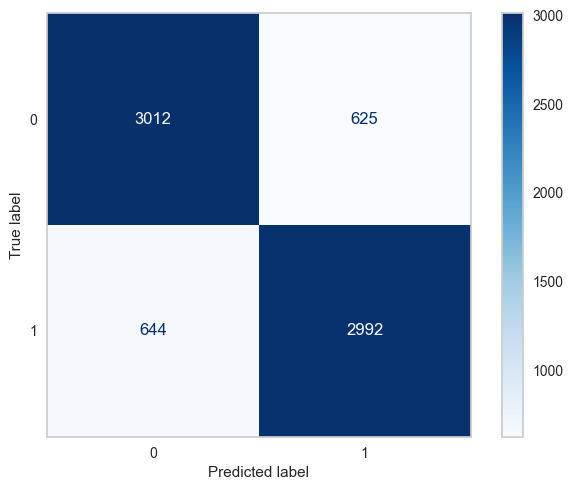

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=search.classes_)
disp.plot(cmap="Blues")
# plt.title("Confusion Matrix")
plt.gca().grid(False)
plt.show()
# disp.plot()

In [93]:
feature = pd.DataFrame({'Feature': obj_exp.get_config('X_train_transformed').columns.values, 'Value' : np.round(xgb_model.feature_importances_,3)*10}).sort_values(by='Value', ascending=True)
feature = feature[feature.Value >=.05]
feature["Feature"].values

array(['map_1_Overpass', 'best_of', 'team', 'opponent', 'map_3_Vertigo',
       'map_1_Mirage', 'map_2_Mirage', 'map_3_Mirage', 'match_win'],
      dtype=object)

In [94]:
import plotly.express as px

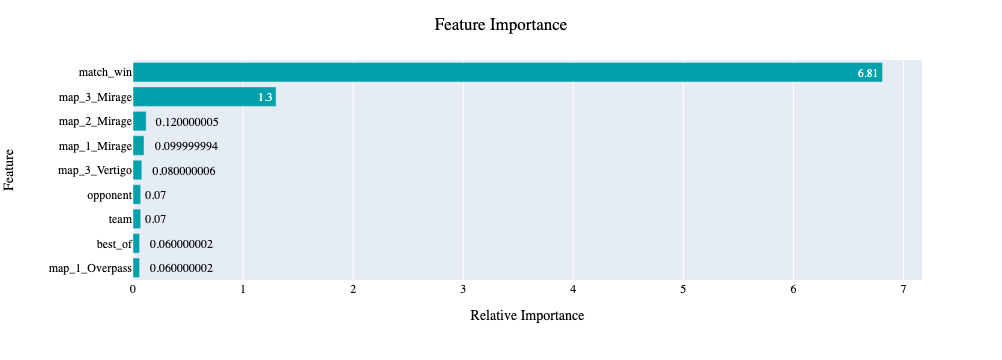

In [95]:
fig = px.bar(feature,y ="Feature", x="Value",orientation='h',text_auto=True,color_discrete_sequence=['#00a1aa'])
fig.update_layout(font_family="Nunito, sans-serif;",font_color="black",title_font_family="Nunito, sans-serif;",title_font_color="black")
fig.update_layout(title_text="Feature Importance", title_x=0.5)
fig.update_layout(xaxis_tickformat = ',')
fig.update_xaxes(title="Relative Importance")
fig

In [97]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


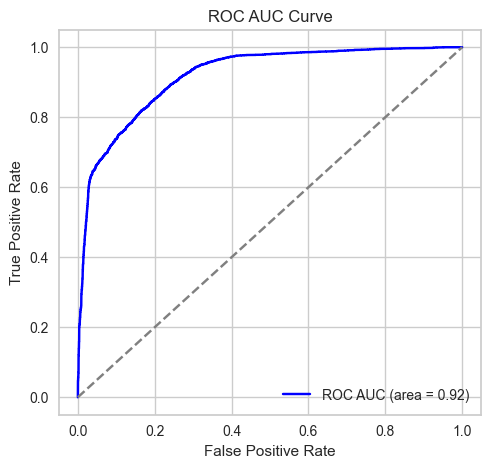

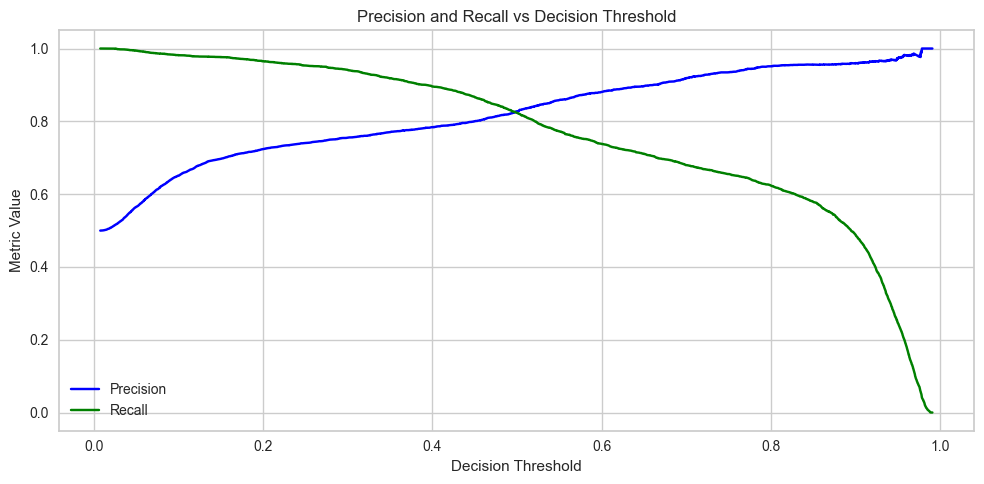

In [111]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Step 5: Precision-Recall curve metrics
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

# Step 6: Plot the ROC AUC curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'ROC AUC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')

# Plot the Precision-Recall curve
# Step 4: Precision-Recall curve metrics
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# Step 5: Plot Precision and Recall against thresholds
plt.figure(figsize=(10, 5))

plt.plot(thresholds, precision[:-1], label='Precision', color='blue')
plt.plot(thresholds, recall[:-1], label='Recall', color='green')

plt.xlabel('Decision Threshold')
plt.ylabel('Metric Value')
plt.title('Precision and Recall vs Decision Threshold')
plt.legend()

plt.tight_layout()
plt.show()

PermutationExplainer explainer: 7274it [03:17, 35.13it/s]                          


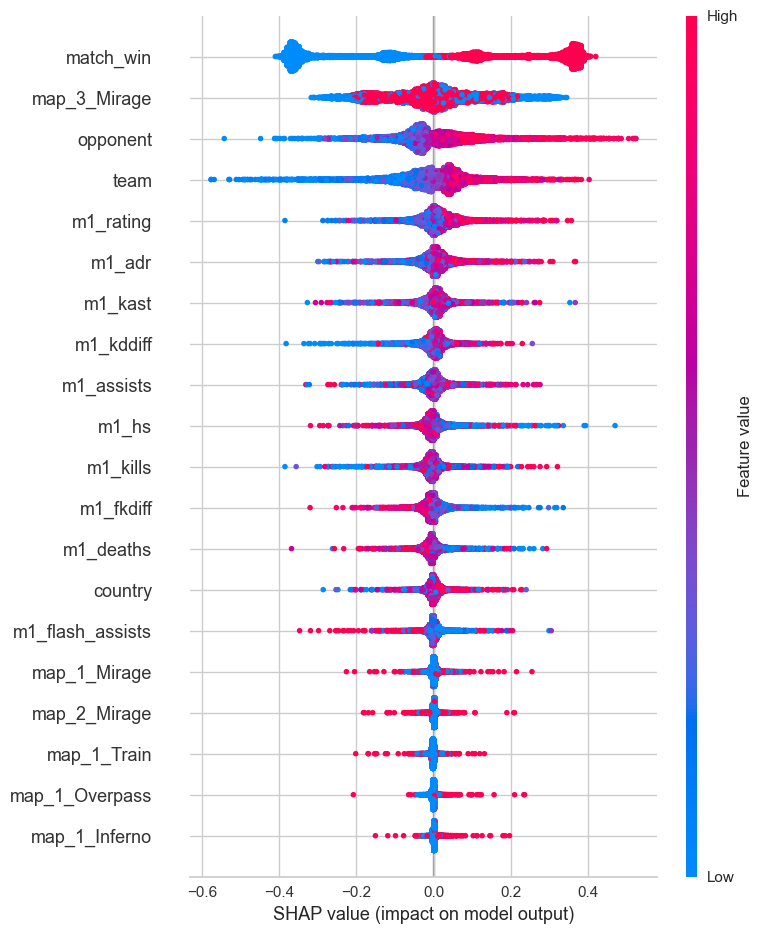

In [112]:
import shap
data = obj_exp.get_config('test_transformed')
X_test = data.drop(['team_won'], axis=1)
y_test = data['team_won']
data = data.apply(pd.to_numeric, errors='coerce')
# Creating an explainer using SHAP
explainer = shap.Explainer(xgb_model.predict, data.drop(columns=['team_won']))

# Getting SHAP values
shap_values = explainer(data.drop(columns=['team_won']))

# Visualize SHAP values in different ways
shap.summary_plot(shap_values, data.drop(columns=['team_won']))


In [113]:
X_test = data.drop(['team_won'], axis=1)
y_test = data['team_won']

In [114]:
def find_false_negatives(y, y_pred):
    """
    Identify the indices of False Negatives (FN) occurrences.
    
    Parameters:
    - y: Actual labels (list or array-like)
    - y_pred: Predicted labels (list or array-like)
    
    Returns:
    - List of indices where False Negatives occur.
    """
    false_negatives = [i for i, (actual, pred) in enumerate(zip(y, y_pred)) if actual == 1 and pred == 0]
    return false_negatives

In [115]:
import numpy as np

In [116]:
# Assuming gbc is your trained Gradient Boosting Classifier
probabilities = gbc.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

# Apply the new threshold
predictions = np.where(probabilities > 0.2, 1, 0) 
false_negative_list = find_false_negatives(y_test.to_list(), list(predictions))
# false_negative_list = find_false_negatives(y_test.to_list(), list(gbc.predict(X_test)))

In [117]:
np.array(false_negative_list)

array([  22,   53,   69,  119,  130,  177,  185,  250,  255,  264,  270,
        280,  304,  339,  365,  412,  414,  425,  478,  510,  514,  541,
        608,  658,  683,  742,  822,  830,  866,  917,  973, 1007, 1032,
       1070, 1087, 1106, 1117, 1158, 1291, 1311, 1348, 1367, 1429, 1455,
       1473, 1557, 1602, 1722, 1770, 1833, 1855, 1908, 1930, 1994, 1998,
       2021, 2161, 2179, 2180, 2242, 2273, 2358, 2430, 2437, 2447, 2449,
       2509, 2549, 2550, 2629, 2662, 2704, 2786, 2787, 2794, 2818, 2824,
       2841, 2891, 2928, 2946, 2990, 3006, 3055, 3064, 3065, 3156, 3166,
       3188, 3198, 3233, 3296, 3326, 3360, 3416, 3424, 3456, 3503, 3550,
       3561, 3674, 3707, 3718, 3795, 3821, 3867, 3882, 3906, 3907, 3967,
       3998, 4035, 4062, 4073, 4083, 4117, 4119, 4165, 4179, 4181, 4199,
       4274, 4275, 4277, 4299, 4317, 4338, 4357, 4378, 4379, 4382, 4403,
       4449, 4528, 4605, 4645, 4652, 4654, 4678, 4705, 4729, 4773, 4795,
       4799, 4820, 4874, 4930, 4940, 4985, 4998, 51

In [118]:
pd.DataFrame({'Feature': X_test.columns.values,
                        'Value' : np.around(np.mean((shap_values[false_negative_list].values), axis=0), decimals=3)
                       }).sort_values(by='Value', ascending=True).head(5)

,Feature,Value
42,match_win,-0.152
0,team,-0.114
23,map_3_Mirage,-0.073
1,opponent,-0.046
34,m1_deaths,-0.015


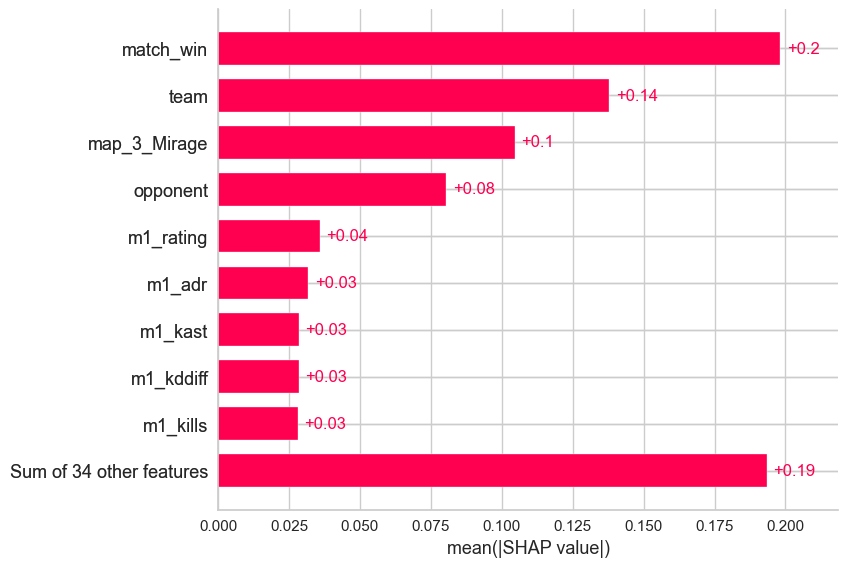

In [119]:
shap.plots.bar(shap_values[false_negative_list])

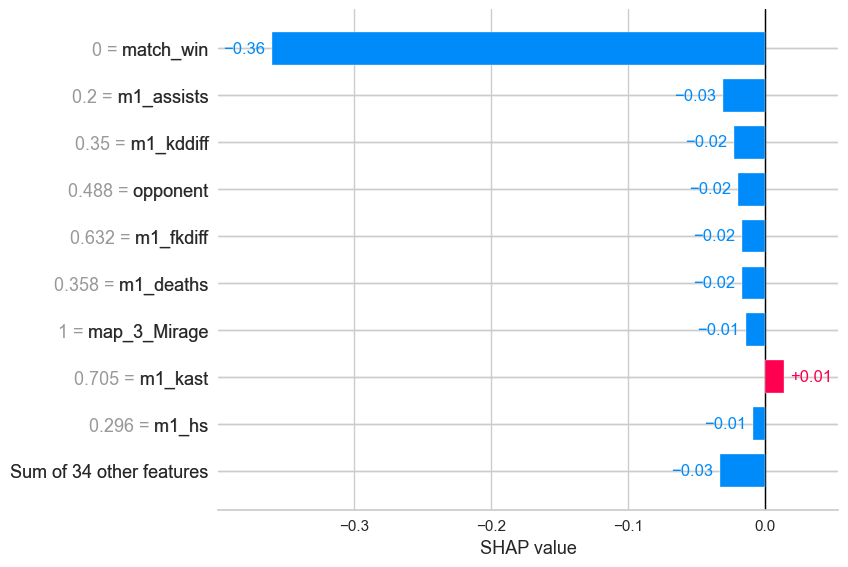

In [121]:
shap.plots.bar(shap_values[22])